## Analyzing the World Happiness Data: Computing Linear Regressions Among Variables
In this exercise, we will use scikit-learn to compute linear regressions among some of the variables in the World Happiness Report (WHR) data set. 

### Import Packages

Before you get started, import a few packages. Run the code cell below. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

We will also import the scikit-learn linear model `LinearRegression`, the `train_test_split()` function for splitting the data into training and test sets, and the metrics `mean_squared_error` and `r2_score` to evaluate our models.

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Step 1: Build Your DataFrame and Define Your ML Problem

#### Load a Data Set and Save it as a Pandas DataFrame

Execute the next few code cells to load and reconfigure the data. Rather than examining the full dataset, we will just examine the data from 2015-2017, which we will store in a DataFrame named ```df1517```.

In [3]:
dfraw = pd.read_excel('WHR2018Chapter2OnlineData.xls', sheet_name='Table2.1')

In [4]:
cols_to_include = ['country', 'year', 'Life Ladder', 
                   'Positive affect','Negative affect',
                   'Log GDP per capita', 'Social support',
                   'Healthy life expectancy at birth', 
                   'Freedom to make life choices', 
                   'Generosity', 'Perceptions of corruption']
renaming = {'Life Ladder': 'Happiness', 
            'Log GDP per capita': 'LogGDP', 
            'Social support': 'Support', 
            'Healthy life expectancy at birth': 'Life', 
            'Freedom to make life choices': 'Freedom', 
            'Perceptions of corruption': 'Corruption', 
            'Positive affect': 'Positive', 
            'Negative affect': 'Negative'}
df = dfraw[cols_to_include].rename(renaming, axis=1)
df1517 = df[df.year.isin(range(2015,2018))]
df1517 = df1517.dropna() # remove missing values
df1517.head()

,country,year,Happiness,Positive,Negative,LogGDP,Support,Life,Freedom,Generosity,Corruption
7,Afghanistan,2015,3.98,0.55,0.34,7.47,0.53,51.69,0.39,0.09,0.88
8,Afghanistan,2016,4.22,0.56,0.35,7.46,0.56,52.02,0.52,0.06,0.79
9,Afghanistan,2017,2.66,0.50,0.37,7.46,0.49,52.34,0.43,-0.11,0.95
17,Albania,2015,4.61,0.69,0.35,9.30,0.64,68.69,0.70,-0.09,0.88
18,Albania,2016,4.51,0.68,0.32,9.34,0.64,68.87,0.73,-0.02,0.90


The World Happiness Report is generally interested in how self-reported `Happiness` (Life Ladder) is dependent on the variety of different factors that they measure (`LogGDP`, `Support`, `Life`, etc.).  The report carries out a detailed analysis explaining how much of each country's `Happiness` can be ascribed to each of the explanatory factors.  We will consider later the specific analysis carried out in the WHR, but start here with a simpler analysis.

 

### Visualize Variables of Interest

Happiness and LogGDP in the WHR data are generally well correlated. Let's first examine a plot demonstrating this relationship. We will use the seaborn function `sns.regplot()` which will create a scatterplot of one feature `LogGDP` and one label `Happiness`, and overlay a line of best fit. 

Run the code cell below and examine the results. You'll notice a linear relationship between the two variables.

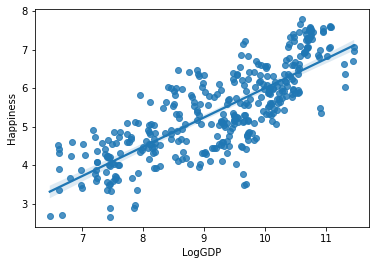

In [5]:
sns.regplot(x='LogGDP', y='Happiness', data=df1517);

Visually, the relationship between the two variables plotted above looks something like a line, albeit with a fair amount of jitter above and below that line. 

Linear regression is a method that estimates a relationship between two variables by fitting a line to examples relating those variables.  That is, given a set of examples relating two variables, linear regression creates a <b>model</b> of the data by assuming that the data relationship is well described by a straight line &mdash; more specifically, a straight line *is* the model of the data.  Given our assumption that a line is a good description of the data relationship, we need to identify what is the specific line that best fits our particular dataset.

Note: the features are also referred to as independent variables, and the label is also referred to as the dependent variable.

Mathematically, a line relating an independent variable $x$ and a dependent variable $y$ is characterized by two parameters: the slope and the y-intercept.  Mathematically, we might write:

$$y = \alpha + w_1 x_1$$

where $w_1$ represents the slope (or weight) and $\alpha$ represents the y-intercept.  The y-intercept is where the line crosses the y-axis (i.e., for $x = 0$), and the slope indicates how a change $\Delta x$ in the independent variable corresponds to a change $\Delta y$ in the dependent variable (the slope is given $w_1 = \Delta y / \Delta x$).

In our case, we are interested in quantifying the relationship between `Happiness` and `LogGDP`, so we are interested in a specific model of the form:

$${\rm Happiness} = \alpha + w_1 * {\rm LogGDP}$$

Linear regression attempts to find the <b>best-fit line</b> that minimizes the least-squares error, that is, the squared difference between the actual training data's label and the model predicted label given by the equation above, summed over all examples. That is, linear regression produces a specific estimate for the model parameters $w_1$ and $\alpha$ that does the best job of fitting the examples.

Visually, we can see that the weight of the general trend in the data is approximately equal to 1, because the y-axis increases by around 4 units (`Happiness` increasing from approximately 3 to 7) at the same time that the x-axis also increases by around 4 units (`LogGDP` going from 7 to 11).  It is harder to estimate the intercept of the dataset, since at `LogGDP=7`, the data are far from the y-axis at $x = 0$.  You should recognize that some estimates for the model parameters $w_1$ and $\alpha$ would do a poor job of describing the data.  If we chose the weight to be $w_1=100$, for example, then our model would be predicting a much more rapid rise than we see in the actual data.  Or if we chose a very large intercept such as $\alpha=1000$, the model predictions would lie far above the data.  But we don't need to rely on visual inspection, since we can use tools to estimate these model parameters numerically.  (This is part of a general process typically referred to as "parameter estimation" or "estimating parameters from data", but it should be recognized that parameter estimation always occurs within the context of some assumed model, such as the straight line we are using here.)

The method from scikit-learn that we will use specifically is called Ordinary Least Squares (OLS), which is the simplest of linear regression methods to estimate the model parameters that minimize the mean-squared error (MSE) between the actual data and the model predictions. The MSE is computed as:

$$ \text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 $$

where $y_i$ is the $i$th example's label and $\hat{y}_i$ is the regression model's predicted value. OLS chooses to minimize the MSE loss function. There are many possible loss functions for a regression problem and they will all give different results. The MSE is one of the simplest and most theoretically understood.



### Define the Label and Identify Features

We will create a <b>simple linear regression</b> model that finds the linear relationship between one feature and one label. We will use the `LogGDP` feature and the `Happiness` label. Our model will predict a `Happiness` value for a given `LogGDP` value. This is a regression problem.


## Step 2: Create Labeled Examples from the Data Set 

Let's extract the feature and label columns from our data set to create labeled examples. The code cell below carries out the following steps:

* Extracts the `LogGDP` column from DataFrame ```df1517``` and assigns it to the variable ```X```. This will be our feature. **The code uses the scikit-learn```to_frame()``` method on `X` to keep it as a Pandas DataFrame instead of a series. This is important for the LinearRegression `fit()` method in scikit-learn.**
* Extracts the `Happiness` column from DataFrame ```df1517``` and assigns it to the variable ```y```. This will be our label.
* Prints the values of `X` and `y`


Execute the code cell below and inspect the results. You will see that we have 380 labeled examples. Each example contains one feature (`LogGDP`) and one label (`Happiness`).

Our goal will be to fit a straight line relating the data in ```X``` to the data in ```y```.


In [6]:
X = df1517['LogGDP'].to_frame()
y = df1517['Happiness']

print(X)
print(y)


      LogGDP
7       7.47
8       7.46
9       7.46
17      9.30
18      9.34
...      ...
1548    8.20
1549    8.21
1559    7.56
1560    7.54
1561    7.54

[380 rows x 1 columns]
7      3.98
8      4.22
9      2.66
17     4.61
18     4.51
       ... 
1548   4.35
1549   3.93
1559   3.70
1560   3.74
1561   3.64
Name: Happiness, Length: 380, dtype: float64


## Step 3: Create Training and Test Data Sets

Now that we have specified examples, we will need to split them into a training set, which we will use to estimate the model parameters $w_1$ and $\alpha$, and a test set, which we will use to understand the performance of our model on new data. 


Run the code cell below to run the ```train_test_split()``` function with `X` and `y` as inputs, along with the parameters:
* `random_state=42` to ensure reproducible output each time the function is called
* `test_size=0.15`, which will randomly set aside 15% of the data to be used for testing. 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## Step 4: Train a Linear Regression Model

Now let's carry out the regression. Let's create a ```LinearRegression``` model object, and then fit the model to the training data, which is the process by which the best-fit model parameters are estimated.

The code cell below:

1. Creates a ```LinearRegression``` model object and assigns the result to the variable ```model```.  You might find it useful to consult the scikit-learn [documentation](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares).
2. Calls the ```model.fit()``` method to fit the model to the training data. 
3. The cell below uses the ```model.predict()``` method with the argument ```X_test``` to use the trained linear regression model to predict values for the test data. It stores the outcome in the variable ```prediction```. We will compare these values to ```y_test``` later.


In [8]:
# Create the  LinearRegression model object 
model = LinearRegression()

# Fit the model to the training data 
model.fit(X_train, y_train)

#  Make predictions on the test data 
prediction = model.predict(X_test)

Let's inspect the model parameters that were determined during training.

* The weights $w$ are stored in numpy array ```model.coef_```. To access a particular weight, such as $w_1$, index into the array using the notation ```model.coef_[0]```. Note that we are using index notation, so the weight of feature 1 is found in element 0 of the NumPy array, the weight of feature 2 is found in element 1 of the NumPy array, and so on.
* The intercept $\alpha$ is stored in ```model.intercept_```. 

Run the cell below and examine the results.

In [9]:
# Weight_1 (weight of feature LogGDP)
print('Model Summary\n\nWeight_1 =  ', model.coef_[0], '[ weight of feature LogGDP ]')
# alpha
print('Alpha = ', model.intercept_, '[ intercept ]')

Model Summary

Weight_1 =   0.7743413443351356 [ weight of feature LogGDP ]
Alpha =  -1.7506833275873177 [ intercept ]


We can translate the output above the following way: the training phase has identified that the best straight-line model fitting `Happiness` to `LogGDP` is approximately:

$${\rm Happiness} = 0.7743 * {\rm LogGDP} - 1.7507$$

In the visual estimation of the slope that was done in <b>Step 2</b>, we noted that the slope should be approximately equal to 1.  That turned out to be an over-estimate since the best-fit value is actually around 0.77, but it's not wildly off.

## Step 5: Evaluate the Model on the Test Set

Now that we have trained the model and made some predictions we will want to examine how well the model performed.

To evaluate our model, we will compute the RMSE (root mean square error) on the test set. RMSE is a metric used to evaluate Regression models. Root Mean Square Error (RMSE) finds the differences between the predicted values and the actual values. 

To compute the RMSE, we will use the scikit-learn ```mean_squared_error()``` function, which computes the MSE between ```y_test``` and ```prediction```. We will then take the square root of the result to obtain the RMSE. 

Finally, we will use the coefficient of determination, also known as $R^2$. $R^2$ is a measure of the proportion of variability in the prediction that the model was able to make using the input data. An $R^2$ value of 1 is perfect and 0 implies no explanatory value. We can use scikit-learn's ```r2_score()``` function to compute it. Run the code below and examine the results.

In [10]:
# The mean squared error
print('\nModel Performance\n\nRMSE =   %.2f'
      % np.sqrt(mean_squared_error(y_test, prediction)))
# The coefficient of determination: 1 is perfect prediction
print(' R^2 =   %.2f'
      % r2_score(y_test, prediction))


Model Performance

RMSE =   0.73
 R^2 =   0.56


Examining the evaluation metrics, we have an RMSE of 0.71. This means that, on average, our predictions are off by 0.71 units. Since the `Happiness` feature in our data set ranges between about 2.5 and 8, this result is not bad! To truly evaluate this we would want to compare this result to the RMSE when using another simpler model, such as using the mean value of the `Happiness` feature as our prediction for every value of ```LogGDP```. 

The $R^2$ value of 0.62 implies that 62% of the variation in the ```Happiness``` feature was explained with the model by variation in ```LogGDP```. There is some subjectivity to interpreting what value is sufficient to justify the use of the model here, but let's just say that in the social sciences, it could also be a lot worse than 56%!

## Step 6: Visualize the Model

We can plot the data and the fit together using Matplotlib. The code cell below:

* Uses ```plt.scatter()``` to plot ```X``` and ```y```. It sets the point size s to a reasonable value to prevent overplotting of points on top of each other.
* Uses ```plt.plot()``` to add a blue line to the plot using the values in ```X_test``` and ```prediction```.
* Uses ```plt.xlabel()``` and ```plt.ylabel()``` to label the axes appropriately. 
* The plot should look similar to the ```sns.regplot()``` created earlier in Step 2. 

Execute the code cell below and inspect the results.

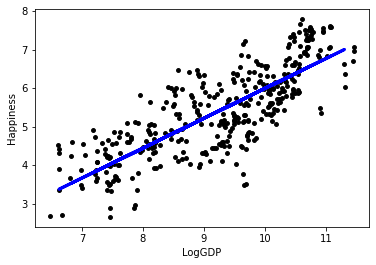

In [11]:
plt.scatter(X, y,  color='black',s=15);

plt.plot(X_test, prediction, color='blue', linewidth=3);

plt.xlabel('LogGDP');
plt.ylabel('Happiness');


## Step 7: Create Labeled Examples for Multiple Linear Regression

Simple linear regression finds the linear relationship between one feature and one label, and multiple regression finds the linear relationship between multiple features and one label. 

We just performed a simple linear regression and found a relationship between `LogGDP` and `Happiness`.

But we are not just interested in how `Happiness` depends on `LogGDP`, but how it relates to the full set of features collected in the WHR data: `LogGDP`, `Support`, `Life`, `Freedom`, `Generosity`, and `Corruption`.  To analyze this full set of dependencies, we can set up a multiple linear regression, which aims to fit a label $y$ to a group of features $X$, by assuming that $y$ depends on each individual feature $X_i$ separately and in a linear manner.  Instead of a single weight $w_1$ as in the simple regression problem, there will now be a separate weight for each feature, i.e.:

$${\rm Happiness} =\alpha + [w_1 * {\rm LogGDP}] + [w_2 * {\rm Support}] + [w_3 * {\rm Life}] +[w_4 * {\rm Freedom}] + [w_5 * {\rm Generosity}] + [w_6 * {\rm Corruption}]$$

The code cell below creates the labeled examples for the multiple regression problem, similar as to what we did above. It performs the following tasks:

* Assigns to the variable ```features``` the list of column names for the features of interest.
* Assigns to the variable ```y``` the `Happiness` columns in the ```df1517``` DataFrame.
* Assigns to the variable ```X``` the columns in ```df1517``` that are listed in `features` . **Since you are extracting multiple columns from ```df1517``` the result will be a DataFrame. You do not have to coerce it back to one like you did before using .to_frame()**
* Prints the value of ```X``` to verify that it has been constructed correctly


In [12]:
features = ['LogGDP', 'Support', 'Life', 'Freedom', 'Generosity', 'Corruption']

X = df1517[features]
y = df1517['Happiness']

print(X)


      LogGDP  Support  Life  Freedom  Generosity  Corruption
7       7.47     0.53 51.69     0.39        0.09        0.88
8       7.46     0.56 52.02     0.52        0.06        0.79
9       7.46     0.49 52.34     0.43       -0.11        0.95
17      9.30     0.64 68.69     0.70       -0.09        0.88
18      9.34     0.64 68.87     0.73       -0.02        0.90
...      ...      ...   ...      ...         ...         ...
1548    8.20     0.77 53.27     0.81        0.11        0.77
1549    8.21     0.74 53.80     0.82        0.13        0.74
1559    7.56     0.74 50.93     0.67       -0.09        0.81
1560    7.54     0.77 51.80     0.73       -0.07        0.72
1561    7.54     0.75 52.67     0.75       -0.07        0.75

[380 rows x 6 columns]


## Step 8: Create Training and Test Data Sets


The code cell below calls `train_test_split()` on ```X``` and ```y```.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## Step 9: Train a Multiple Linear Regression Model

Similar to what we did above, now let's create an OLS model for the multiple linear regression.

In [14]:
# Create the  LinearRegression model object 
model2 = LinearRegression()

# Fit the model to the training data 
model2.fit(X_train, y_train)

#  Make predictions on the test data 
prediction2 = model2.predict(X_test)

Examine the model parameters.

In [15]:
print('Model Summary:\n')

# Print intercept (alpha)
print('Intercept:')
print('alpha = ' , model2.intercept_)

# Print weights
print('\nWeights:')
i = 0
for w in model2.coef_:
    print('w_',i+1,'= ', w, ' [ weight of ', features[i],']')
    i += 1

Model Summary:

Intercept:
alpha =  -2.424946074311782

Weights:
w_ 1 =  0.29508992828666314  [ weight of  LogGDP ]
w_ 2 =  2.846499616214751  [ weight of  Support ]
w_ 3 =  0.03215494406489183  [ weight of  Life ]
w_ 4 =  1.5133471841693855  [ weight of  Freedom ]
w_ 5 =  0.29026637012541634  [ weight of  Generosity ]
w_ 6 =  -0.5175437220884864  [ weight of  Corruption ]


## Step 10: Evaluate the Model on the Test Set

Run the cell below to examine the metrics.

In [16]:
# Print mean squared error
print('\nModel Performance\n\nRMSE =   %.2f'
      % np.sqrt(mean_squared_error(y_test, prediction2)))
# The coefficient of determination: 1 is perfect prediction
print(' R^2 =   %.2f'
      % r2_score(y_test, prediction2))


Model Performance

RMSE =   0.62
 R^2 =   0.68


## Step 11: Conclusions

Examine the output in the Model Summary.  Estimates of model parameters are now provided for all of the features, as well as the overall intercept.  Note that the estimates for the intercept and the `LogGDP` weight are different than was the case in the simple regression.  That is typical, since multiple regression accounts for relationships between each independent and dependent variable once all the other data relationships are taken into account.

We can see from the summary results that the `Support` and `Freedom` variables have the largest weights, indicating that, on average, an increase in those variables corresponds to an increase in `Happiness`. `Corruption` has a negative weight implying that, on average, a decrease in that feature corresponds to an increase in `Happiness`. These results fit with our common sense which is always important to verify.

We also see that our RMSE has decreased and our $R^2$ value has increased, both good indicators that adding more features has increased the accuracy and fit of the model (although it is important to note that adding variables will always increase $R^2$ and that the magnitude of the increase may differ depending on the variable)!


## Deep Dive: Iterative Approach - Gradient Descent

OLS is a non-iterative linear regression. If you have a regression problem that will benefit from using the iterative approach that uses the optimization algorithm Gradient Descent, scikit-learn makes it easy for you. You can simply use the `SGDRegressor` class in place of the `LinearRegression` class. (Note that `SGDRegressor` uses a type of Gradient Descent algorithm called Stochastic Gradient Descent). 

Essentially, you would replace the line ``model = LinearRegression()`` with the line ``model = SGDRegressor(loss='squared_loss', max_iter=1000, tol=1e-3, learning_rate='constant')``, but supplying the arguments of your choosing. You'll note that `SGDRegressor` allows you to specify which loss function to use, and the max number of iterations over your training data (epochs). It will also allow you to set hyperparameters, such as the `learning rate`. Once you train your model, you can evaluate the model's performance, and run the `SGDRegressor` again with different hyperparameter arguments.

You can consult the [scikit-learn documentation on SGDRegressor](https://scikit-learn.org/stable/modules/linear_model.html#stochastic-gradient-descent-sgd) for more information. 